In [1]:
import yt
import ytree
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

### Load Arbor and Redshift Array

#### Filter Redshifts

I am not interested in extremely high redshifts since stars haven't formed yet, so here I set a maximum redshift.

I also found that the datasets for some redshifts produced bad data (specifically for the radiation quantities), so I exclude them from my analysis here.

In [3]:
# Load ytree arbor and array of redshifts.
a = ytree.load('full_arbor/full_arbor.h5')
redshifts = np.load('stored_arrays/ytree_redshifts.npy')

# Set the maximum redshift to be included in analysis.
max_redshift = 12.

# Identify any bad datasets.
bad_redshifts = np.array([redshifts[23], redshifts[30]])
# Create mask to exlude high redshifts and bad redshifts.
mask = (redshifts < max_redshift)*[redshift not in bad_redshifts for redshift in redshifts]

# Update redshift array to include only redshifts of interest.
redshifts = redshifts[mask]

### Create List of Halos of Interest

Halo mass is the primary factor determining Pop III star formation. Below some lower mass threshold, no halos form Pop III stars. Above some upper mass threshold, all halos form stars. To determine what other halo features affect Pop III star formation, I restrict my analysis to halos within the intermediate mass range between the least massive Pop III halo and the most massive no-star halo.

I also restrict my analysis to halos that have > 250 dark matter particles to ensure sufficient virialization. I determine this from the mass stored in the ytree arbor from ROCKSTAR which includes just the mass of dark matter particles.

The final list of halos for analysis includes halos that:
* Have ytree masses above the minimum mass for virialization
* Have a sphere mass that is within the intermediate mass range as described above
* Contain no star particles within their virial radius or are the most massive progenitors of a Pop III halo
* Exist within the acceptable redshift range excluding any bad datasets

In [4]:
# Set minimum mass threshold for virialization. ~250 DM particles.
min_mass_threshold = 5e5

# Select all Pop III progenitor halos.
hlist = a.select_halos("tree['tree', 'is_popiii_progenitor'] == 1", fields=['is_popiii_progenitor'])
# Select only Pop III progenitor halos that are in redshifts of interest.
progenitors = np.array([halo for halo in hlist if halo['redshift'] in redshifts])

print('Number of progenitor halos:', len(progenitors))

# Set the overall minimum mass to be the minimum of the Pop III progenitor halo masses.
masses = [halo['sphere_mass'] for halo in progenitors]
min_mass = np.min(masses)

# Select all no-stars above the minimum mass threshold.
hlist = a.select_halos("(tree['tree', 'sphere_stellar_mass'] == 0) & (tree['tree', 'mass'] > {})"\
                       .format(min_mass_threshold), fields=['sphere_stellar_mass', 'mass'])
# Select only no-star halos that are in redshifts of interest.
no_star_halos = np.array([halo for halo in hlist if halo['redshift'] in redshifts])

print('Number of no-star halos:', len(no_star_halos))

# Set the overall maximum mass to be the maximum of the no-star halo masses.
masses = [halo['sphere_mass'] for halo in no_star_halos]
max_mass = np.max(masses)

print('Minimum mass (Msun):', min_mass)
print('Maximum mass (Msun):', max_mass)

# Select halos within min_mass and max_mass.
# Must be above minimum mass threshold for virialization.
# Must either have no stars or be a Pop III progenitor halo.
hlist = a.select_halos("(tree['tree', 'mass'] > {}) & (tree['tree', 'sphere_mass'] > {}) & \
                        (tree['tree', 'sphere_mass'] < {}) & ((tree['tree', 'sphere_stellar_mass'] == 0) | \
                        (tree['tree', 'is_popiii_progenitor'] == 1))"\
                       .format(min_mass_threshold, min_mass, max_mass), fields=['mass', 'sphere_mass'])

# Select only halos that are in the redshifts of interest.
halos = np.array([halo for halo in hlist if halo['redshift'] in redshifts])

/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
Setting up trees:   0%|          | 0/4681 [00:00<?, ?it/s]/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/

Number of progenitor halos: 55


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
Getting fields:   0%|          | 0/4681 [00:00<?, ?it/s]/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3279.74it/s]
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWa

Number of no-star halos: 17677


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Minimum mass (Msun): 4358867.967511095
Maximum mass (Msun): 38861821.560513675


Getting fields:   0%|          | 0/4681 [00:00<?, ?it/s]/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
Selecting halos: 100%|██████████| 4681/4681 [00:03<00:00, 1504.15it/s]


### Create Data Arrays for SVC Analysis

Here I create the data array `X` which contains the values for all features that I include in my analysis. Can change how many and which features to include. Features must be fields that are stored in the arbor except for `'mass_growth_sign'` and `'growth_derivative_sign'`. I choose these features so that I can work in log-space but not lose information about all halos that have negative values for these fields.

Some of the halos are new halos and have no growth history. I exclude these from the analysis.

I use a standard scaler on the data which shifts and scales the values for each feature so that the mean is 0 and the standard deviation is 1. This makes the SVC work more effectively.

Since this is a classification problem, I also create an array of labels `y` which labels each halos as either a Pop III progenitor (if the value is 1) or a no-star halos (if the value is 0).

In [6]:
# Create arrays of relevant parameters for each halo.

# List of features to be included in analysis
fields = ['sphere_mass', 'sphere_mass_growth', 'mass_growth_sign', \
          'sphere_mass_growth_derivative', 'growth_derivative_sign', 'number_of_mergers', \
          'neighbor_distance', 'sphere_J21_LW', 'redshift']

# Record the number of halos and features that will be in the data array
num_halos = len(hlist)
num_features = len(fields)

# Create arrays to store data for each halo
halo_data_array = np.zeros((num_halos, num_features))
# Mask to filter out halos that aren't usable (don't have growth history, for example)
good_data = np.ones(num_halos, dtype=bool)

# Iterate through each halo to add its features to the data array.
for i, halo in enumerate(hlist):
    # Iterate through each field to be included to add to the data array.
    for j, field in enumerate(fields):
        # Don't take the log of a redshift
        if field == 'redshift' or field == 'number_of_mergers':
            halo_data_array[i, j] = halo[field]
        elif field == 'mass_growth_sign':
            halo_data_array[i, j] = np.sign(halo['sphere_mass_growth'])
        elif field == 'growth_derivative_sign':
            halo_data_array[i, j] = np.sign(halo['sphere_mass_growth_derivative'])
        # Take log of absolute value of all other fields.
        else:
            halo_data_array[i, j] = np.log10(np.abs(halo[field]))
            # If a field is 0, it is a new halo and has no information about its growth history
            if halo[field] == 0.:
                good_data[i] = False
                
# Do analysis only on good data.
halo_data_array = halo_data_array[good_data]

# Scale the data to improve SVM.
scaler = StandardScaler()
# Array of data. Includes scaled values for each halo feature.
X = scaler.fit_transform(halo_data_array)
# Array of labels for each halo. 1 if it is a Pop III progenitor halo, 0 if it is a no-star halo.
y = np.array([halo['is_popiii_progenitor'] for halo in hlist], dtype=int)[good_data]

print('Total halos:', len(X))
print('Progenitors:', np.sum(y))

/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encou

2003
62


### Support-Vector Classification (SVC)

To validate an SVC model, I use a test-train split. The data are randomly assigned to either the testing set or the training set. The relative sizes of the two sets is a hyperparameter that can be tuned. The classification model is created from the training set. This is where the SVC creates a hyperplane in feature-space that divides between the two classes (no-star halos and Pop III progenitor halos). I then test the model on the testing set to determine how effective it is. If the model does not score well on the testing set, then it is not a generally good model. For example, if it scores very well on the training set but poorly on the testing set, then it is likely overfitting to the training set.

#### Scoring Metrics

There are several ways to determine how effective a model is. The accuracy (the fraction of correct classifications) is the simplest metric though not especially useful for an imbalanced dataset like this one. Since there are so many more no-star halos than there are Pop III progenitor halos, a model could have high accuracy by classifying _every_ halo as a no-star halo even though this is clearly not useful or informative.

More useful scoring metrics are __precision__, __recall__, and the __F1 score__ defined as follows:

* __precision__ = $\frac{\mathrm{true\ positives}}{\mathrm{true\ positives\ +\ false\ positives}}$
* __recall__ = $\frac{\mathrm{true\ positives}}{\mathrm{true\ positives\ +\ false\ negatives}}$
* __F1 score__ = $2 \frac{\mathrm{precision \cdot recall}}{\mathrm{precision\ +\ recall}}$

As a more conceptual description, the precision answers: Of all the halos that the SVC classified as Pop III progenitors, how many actually were? The recall answers: Of all the halos that actually were Pop III progenitors, how many did the SVC classify as such? The F1 score is the harmonic mean of the two, which gives more weight to the lower of the two scores.

I use the F1 score as my primary scoring metric because I want to achieve both high precision and recall, or at least not neglect either score.

#### Hyperparameter Tuning

In the next four cells I run some tests to tune the hyperparameters of the SVC. I vary the values of several of the hyperparameters to determine which SVC model is most effective. I plot the accuracy, precision, recall, and F1 scores and how they vary with the hyperparameters. I use the F1 score to determine the best value for each hyperparameter.

I use a simple method varying each hyperparameter independently. This is likely not the most effective way to accomplish my goal (some kind of hyperparameter grid search would be more effective) though for my purposes I believe it is effective enough.

rbf
C = 0.1 	 0.09203004837036133
C = 0.46415888336127786 	 0.0626535415649414
C = 2.1544346900318834 	 0.04536271095275879
C = 10.0 	 0.03457164764404297
C = 46.41588833612777 	 0.03428959846496582
C = 215.44346900318823 	 0.033112287521362305
C = 1000.0 	 0.037651777267456055
C = 4641.588833612773 	 0.0373988151550293
C = 21544.346900318822 	 0.03747749328613281
C = 100000.0 	 0.03861665725708008

Best F1: 0.15789473684210525
Best C: 0.1


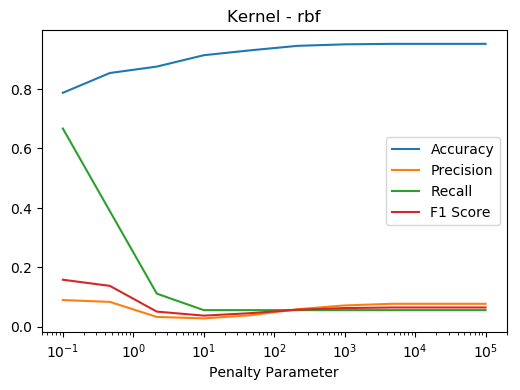

poly
C = 0.1 	 0.0404205322265625
C = 0.46415888336127786 	 0.036403656005859375
C = 2.1544346900318834 	 0.03706979751586914
C = 10.0 	 0.045996665954589844
C = 46.41588833612777 	 0.08543157577514648
C = 215.44346900318823 	 0.20756316184997559
C = 1000.0 	 0.3477630615234375
C = 4641.588833612773 	 0.8265979290008545
C = 21544.346900318822 	 1.050107479095459
C = 100000.0 	 1.8859548568725586

Best F1: 0.1935483870967742
Best C: 21544.346900318822


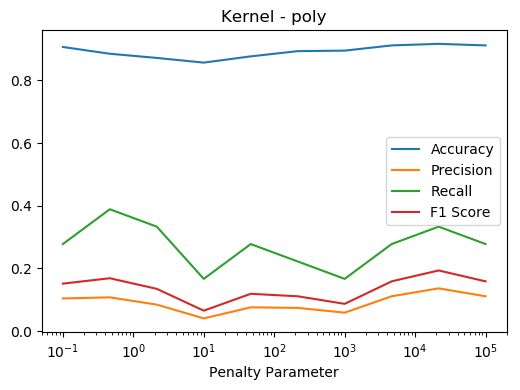

sigmoid
C = 0.1 	 0.07981276512145996
C = 0.46415888336127786 	 0.06331610679626465
C = 2.1544346900318834 	 0.061222076416015625
C = 10.0 	 0.06172537803649902
C = 46.41588833612777 	 0.06186199188232422
C = 215.44346900318823 	 0.061341047286987305
C = 1000.0 	 0.06041765213012695
C = 4641.588833612773 	 0.061662912368774414
C = 21544.346900318822 	 0.06103181838989258
C = 100000.0 	 0.06161808967590332

Best F1: 0.0855614973262032
Best C: 0.1


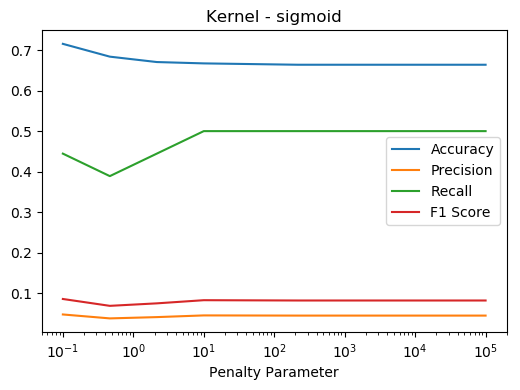

Best kernel: poly
Best kernel score: 0.1935483870967742


In [8]:
# Test different kernels and different penalties

# Perform test-train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Range of penalty parameters to test
penalties = np.logspace(-1, 5, 10)
# Score metrics for each penalty parameter
accuracies = np.zeros_like(penalties)
precisions = np.zeros_like(penalties)
recalls = np.zeros_like(penalties)
f1_scores = np.zeros_like(penalties)

# List of kernels to test
kernels = ['rbf', 'poly', 'sigmoid']

# Set initial best kernel score to 0 so that it will be replaced once any kernels are tested.
best_kernel_score = 0.
best_kernel = kernels[0]

# Loop throug each kernel, testing each penalty parameter.
for kernel in kernels:
    
    print(kernel)
    
    # Set initial best F1 score to 0, so that any score will be better.
    best_f1 = 0.
    best_C = penalties[0]

    for i, C in enumerate(penalties):

        start = time.time()

        svc = SVC(C=C, kernel=kernel, gamma='auto', class_weight='balanced')
        svc.fit(X_train, y_train)

        y_pred = svc.predict(X_test)

        accuracies[i] = accuracy_score(y_test, y_pred)
        precisions[i] = precision_score(y_test, y_pred)
        recalls[i] = recall_score(y_test, y_pred)
        f1_scores[i] = f1_score(y_test, y_pred)
        
        if f1_scores[i] > best_f1:
            best_f1 = f1_scores[i]
            best_C = C

        end = time.time()

        print('C =', C, '\t', end - start)
        
    print('\nBest F1:', best_f1)
    print('Best C:', best_C)

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_dpi(100)

    plt.semilogx(penalties, accuracies, label='Accuracy')
    plt.semilogx(penalties, precisions, label='Precision')
    plt.semilogx(penalties, recalls, label='Recall')
    plt.semilogx(penalties, f1_scores, label='F1 Score')
    plt.xlabel('Penalty Parameter')
    plt.title('Kernel - {}'.format(kernel))
    plt.legend()
    plt.show()
    
    if best_f1 > best_kernel_score:
        best_kernel_score = best_f1
        best_kernel = kernel
        
print('Best kernel:', best_kernel)
print('Best kernel score:', best_kernel_score)

test_size = 0.3 	 0.06477737426757812
test_size = 0.39999999999999997 	 0.05926227569580078
test_size = 0.5 	 0.038144826889038086
test_size = 0.6 	 0.02846384048461914
test_size = 0.7 	 0.022990942001342773

Best F1: 0.18333333333333335
Best test_size: 0.7


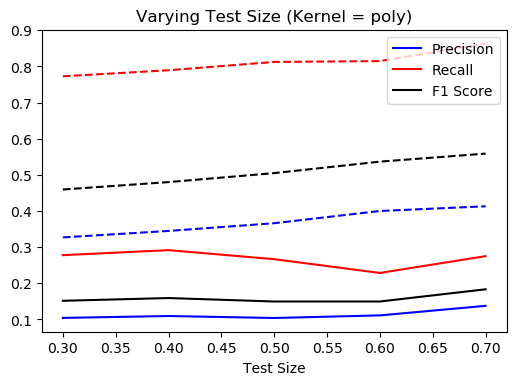

In [10]:
# Test different test sizes using best kernel (rbf)

test_sizes = np.linspace(.3, .7, 5)

# Use best penalty parameter from previous test.
C = best_C

test_accuracies = np.zeros_like(test_sizes)
test_precisions = np.zeros_like(test_sizes)
test_recalls = np.zeros_like(test_sizes)
test_f1_scores = np.zeros_like(test_sizes)

train_accuracies = np.zeros_like(test_sizes)
train_precisions = np.zeros_like(test_sizes)
train_recalls = np.zeros_like(test_sizes)
train_f1_scores = np.zeros_like(test_sizes)

kernel = best_kernel

best_f1 = 0.
best_test_size = test_sizes[0]

for i, test_size in enumerate(test_sizes):

    start = time.time()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)

    svc = SVC(C=C, kernel=kernel, gamma='auto', class_weight='balanced')
    svc.fit(X_train, y_train)

    # Make predictions for test set.
    y_pred = svc.predict(X_test)

    test_accuracies[i] = accuracy_score(y_test, y_pred)
    test_precisions[i] = precision_score(y_test, y_pred)
    test_recalls[i] = recall_score(y_test, y_pred)
    test_f1_scores[i] = f1_score(y_test, y_pred)

    # Make predictions for training set.
    y_pred = svc.predict(X_train)

    train_accuracies[i] = accuracy_score(y_train, y_pred)
    train_precisions[i] = precision_score(y_train, y_pred)
    train_recalls[i] = recall_score(y_train, y_pred)
    train_f1_scores[i] = f1_score(y_train, y_pred)

    if test_f1_scores[i] > best_f1:
        best_f1 = test_f1_scores[i]
        best_test_size = test_size

    end = time.time()

    print('test_size =', test_size, '\t', end - start)

print('\nBest F1:', best_f1)
print('Best test_size:', best_test_size)

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

#plt.plot(test_sizes, accuracies, label='Accuracy')
plt.plot(test_sizes, test_precisions, 'b-', label='Precision')
plt.plot(test_sizes, test_recalls, 'r-', label='Recall')
plt.plot(test_sizes, test_f1_scores, 'k-', label='F1 Score')
plt.plot(test_sizes, train_precisions, 'b--')
plt.plot(test_sizes, train_recalls, 'r--')
plt.plot(test_sizes, train_f1_scores, 'k--')
plt.xlabel('Test Size')
plt.title('Varying Test Size (Kernel = {})'.format(kernel))
plt.legend()
plt.savefig('SVM/test_sizes.png')
plt.show()

0.6116201877593994

Best Test F1: 0.23529411764705882
Best C: 0.01


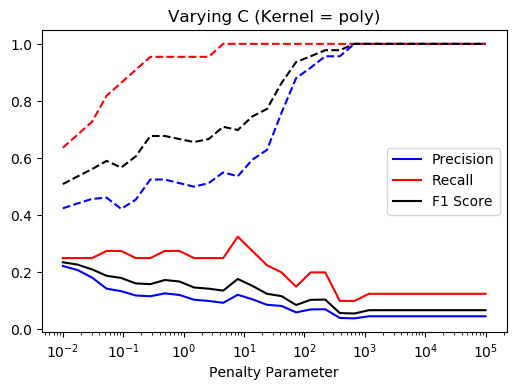

In [12]:
# Refine best kernel with best test_size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=0)

penalties = np.logspace(-2, 5, 30)
test_accuracies = np.zeros_like(penalties)
test_precisions = np.zeros_like(penalties)
test_recalls = np.zeros_like(penalties)
test_f1_scores = np.zeros_like(penalties)

train_accuracies = np.zeros_like(penalties)
train_precisions = np.zeros_like(penalties)
train_recalls = np.zeros_like(penalties)
train_f1_scores = np.zeros_like(penalties)
    
best_f1 = 0.
best_C = penalties[0]

start = time.time()

for i, C in enumerate(penalties):

    svc = SVC(C=C, kernel=best_kernel, gamma='auto', class_weight='balanced')
    svc.fit(X_train, y_train)

    # Make predictions for test set.
    y_pred = svc.predict(X_test)

    test_accuracies[i] = accuracy_score(y_test, y_pred)
    test_precisions[i] = precision_score(y_test, y_pred)
    test_recalls[i] = recall_score(y_test, y_pred)
    test_f1_scores[i] = f1_score(y_test, y_pred)

    # Make predictions for training set.
    y_pred = svc.predict(X_train)

    train_accuracies[i] = accuracy_score(y_train, y_pred)
    train_precisions[i] = precision_score(y_train, y_pred)
    train_recalls[i] = recall_score(y_train, y_pred)
    train_f1_scores[i] = f1_score(y_train, y_pred)

    if test_f1_scores[i] > best_f1:
        best_f1 = test_f1_scores[i]
        best_C = C

end = time.time()

print(end - start)

print('\nBest Test F1:', best_f1)
print('Best C:', best_C)

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.semilogx(penalties, test_precisions, 'b-', label='Precision')
plt.semilogx(penalties, test_recalls, 'r-', label='Recall')
plt.semilogx(penalties, test_f1_scores, 'k-', label='F1 Score')
plt.semilogx(penalties, train_precisions, 'b--')
plt.semilogx(penalties, train_recalls, 'r--')
plt.semilogx(penalties, train_f1_scores, 'k--')
plt.xlabel('Penalty Parameter')
plt.title('Varying C (Kernel = {})'.format(kernel))
plt.legend()
plt.savefig('SVM/penalties.png')
plt.show()

0.23958492279052734

Best F1: 0.23529411764705882
Best tolerance: 0.0001


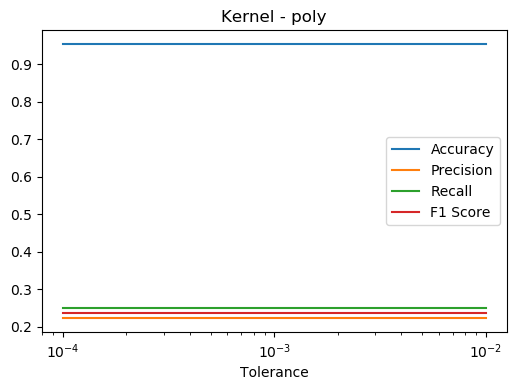

In [13]:
# Test tolerances
tolerances = np.logspace(-4, -2, 10)
accuracies = np.zeros_like(tolerances)
precisions = np.zeros_like(tolerances)
recalls = np.zeros_like(tolerances)
f1_scores = np.zeros_like(tolerances)
    
best_f1 = 0.
best_tolerance = tolerances[0]

start = time.time()

for i, tolerance in enumerate(tolerances):

    svc = SVC(C=best_C, kernel=best_kernel, gamma='auto', class_weight='balanced', tol=tolerance)
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)

    accuracies[i] = accuracy_score(y_test, y_pred)
    precisions[i] = precision_score(y_test, y_pred)
    recalls[i] = recall_score(y_test, y_pred)
    f1_scores[i] = f1_score(y_test, y_pred)

    if f1_scores[i] > best_f1:
        best_f1 = f1_scores[i]
        best_tolerance = tolerance

end = time.time()

print(end - start)

print('\nBest F1:', best_f1)
print('Best tolerance:', best_tolerance)

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.semilogx(tolerances, accuracies, label='Accuracy')
plt.semilogx(tolerances, precisions, label='Precision')
plt.semilogx(tolerances, recalls, label='Recall')
plt.semilogx(tolerances, f1_scores, label='F1 Score')
plt.xlabel('Tolerance')
plt.title('Kernel - {}'.format(kernel))
plt.legend()
plt.show()

### Final Results

Using the best hyperparameters, I rerun the SVC and report the best scores. More information is shown using a confusion matrix where I can see exactly how many true positives, false positives, false negtives, and true negatives the model produced on the test set.

In [14]:
# Create confusion matrix using best values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=0)

svc = SVC(C=best_C, kernel=best_kernel, gamma='auto', class_weight='balanced')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
best_f1 = f1_score(y_test, y_pred)

print('Test Set')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', best_f1)

test_con_matrix = confusion_matrix(y_test, y_pred)

print(test_con_matrix)

Test Set
Accuracy: 0.9536707056307911
Precision: 0.2222222222222222
Recall: 0.25
F1 Score: 0.23529411764705882
[[1328   35]
 [  30   10]]


### Feature Selection

Ultimately I am not just trying to make a model that can effectively classify halos; I am interested in determining which halo features influence Pop III star formation. To do this I perform feature selection. I re-run the same analysis using the best hyperparameters, but each time remove one of the features.

Generally I expect that if some feature is very important for Pop III star formation, then if I remove this feature, the SVC will be much less effective. So I roughly measure the significance of each feature by the amount by which the F1 score decreases with that feature missing.

In [18]:
# Feature Selection

# Create arrays of relevant parameters for each halo.

all_fields = ['sphere_mass', 'sphere_mass_growth', 'mass_growth_sign', \
          'sphere_mass_growth_derivative', 'growth_derivative_sign', 'number_of_mergers', \
          'neighbor_distance', 'sphere_J21_LW', 'redshift']

# Record the number of halos and features that will be in the data array
num_halos = len(hlist)
num_features = len(all_fields)

f1_scores = np.zeros(num_features)

# Cycle through all_fields list and omit one field at a time.
for n, feature in enumerate(all_fields):
    start = time.time()
    
    fields = all_fields[:n] + all_fields[n+1:]

    # Create arrays to store data for each halo and to 
    halo_data_array = np.zeros((num_halos, num_features))
    good_data = np.ones(num_halos, dtype=bool)

    # Iterate through each halo to add its features to the data array.
    for i, halo in enumerate(hlist):
        # Iterate through each field to be included to add to the data array.
        for j, field in enumerate(fields):
            # Don't take the log of a redshift
            if field == 'redshift' or field == 'number_of_mergers':
                halo_data_array[i, j] = halo[field]
            elif field == 'mass_growth_sign':
                halo_data_array[i, j] = np.sign(halo['sphere_mass_growth'])
            elif field == 'growth_derivative_sign':
                halo_data_array[i, j] = np.sign(halo['sphere_mass_growth_derivative'])
            # Take log of absolute value of all other fields.
            else:
                halo_data_array[i, j] = np.log10(np.abs(halo[field]))
                # If a field is 0, it is a new halo and has no information about its growth history
                if halo[field] == 0.:
                    good_data[i] = False

    # Do analysis only on good data.
    halo_data_array = halo_data_array[good_data]

    # Create scaled data
    scaler = StandardScaler()
    X = scaler.fit_transform(halo_data_array)
    y = np.array([halo['is_popiii_progenitor'] for halo in hlist], dtype=int)[good_data]
    
    # Perform test-train split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=0)

    # Create and fit model to test data
    svc = SVC(C=best_C, kernel=best_kernel, gamma='auto', class_weight='balanced')
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_test)

    # Determine performance scores. 
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_scores[n] = f1_score(y_test, y_pred)

    end = time.time()
    
    print('Omitting {}'.format(feature), end - start, sep='\t')
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_scores[n])

/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting sphere_mass	1.9457898139953613
Precision: 0.16216216216216217
Recall: 0.15
F1 Score: 0.15584415584415584


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting sphere_mass_growth	1.964125394821167
Precision: 0.23529411764705882
Recall: 0.2
F1 Score: 0.2162162162162162


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting mass_growth_sign	2.242633581161499
Precision: 0.2127659574468085
Recall: 0.25
F1 Score: 0.2298850574712644


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting sphere_mass_growth_derivative	1.9403808116912842
Precision: 0.2702702702702703
Recall: 0.2222222222222222
F1 Score: 0.24390243902439024


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting growth_derivative_sign	2.3116018772125244
Precision: 0.23404255319148937
Recall: 0.275
F1 Score: 0.25287356321839083


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting number_of_mergers	2.2866084575653076
Precision: 0.22448979591836735
Recall: 0.275
F1 Score: 0.24719101123595505


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting neighbor_distance	1.9269564151763916
Precision: 0.20930232558139536
Recall: 0.225
F1 Score: 0.21686746987951808


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting sphere_J21_LW	2.0384140014648438
Precision: 0.11904761904761904
Recall: 0.125
F1 Score: 0.12195121951219512


/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/yt/units/yt_array.py:1373: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


Omitting redshift	2.3572845458984375
Precision: 0.30434782608695654
Recall: 0.175
F1 Score: 0.2222222222222222


In [22]:
print('Best score with all features:', best_f1, '\n')
    
features = np.array(all_fields)
score_differences = best_f1 - f1_scores
inds = score_differences.argsort()
sorted_scores = score_differences[inds][::-1]
sorted_features = features[inds][::-1]

print('\nMost Important Features (by greatest F1 score decrease):')

# Print the score decreases for each removed feature in descending order.
for n, feature in enumerate(sorted_features):
    print(feature, sorted_scores[n], sep='\t')

Best score with all features: 0.23529411764705882 


Most Important Features (by greatest F1 score decrease):
sphere_J21_LW	0.1133428981348637
sphere_mass	0.07944996180290298
sphere_mass_growth	0.01907790143084262
neighbor_distance	0.018426647767540744
redshift	0.01307189542483661
mass_growth_sign	0.005409060175794428
sphere_mass_growth_derivative	-0.008608321377331418
number_of_mergers	-0.011896893588896229
growth_derivative_sign	-0.01757944557133201
